# Detecting Deep Fakes
---
### author: Telemachos Chatzitheodorou

### Mount drive and import important libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pathlib
import tensorflow_datasets as tfds
import glob
from tensorflow.keras.utils import plot_model

## Autoencoder

In [ ]:
# Functions for dataset preperation
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [256, 256])

def process_path(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, img

def configure_for_performance(ds):
  ds = ds.shuffle(buffer_size=200)
  ds = ds.batch(64)
  return ds

In [ ]:
# Import image paths using tf.data.Dataset
data_dir = os.path.join(os.getcwd(), "/content/drive/MyDrive/DeepFake/dataset1/unlabeled")
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*.jpg')))
list_ds = tf.data.Dataset.list_files(str(data_dir/'*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
# Check if the paths are correct
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/DeepFake/dataset1/unlabeled/65608.jpg'
b'/content/drive/MyDrive/DeepFake/dataset1/unlabeled/57008.jpg'
b'/content/drive/MyDrive/DeepFake/dataset1/unlabeled/08105.jpg'
b'/content/drive/MyDrive/DeepFake/dataset1/unlabeled/41180.jpg'
b'/content/drive/MyDrive/DeepFake/dataset1/unlabeled/52179.jpg'


In [ ]:
# Split train, validation and test datasets
train_size = int(0.7 * image_count)
val_size = int(0.15 * image_count)
test_size = int(0.15 * image_count)

train_ds = list_ds.take(train_size)
tmp_ds= list_ds.skip(train_size)
val_ds = tmp_ds.take(val_size)
test_ds = tmp_ds.skip(val_size)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

7000 1500 1500


In [ ]:
# Build datasets from extracted paths

train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)
test_ds = test_ds.map(process_path)

# Add shuffle, batch to datasets
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [ ]:
for image_batch, label in train_ds.take(1):
  print(image_batch.shape)
  print(label.shape)

(64, 256, 256, 3)
(64, 256, 256, 3)


In [ ]:
for image_batch, label in val_ds.take(1):
  print(image_batch.shape)
  print(label.shape)

(64, 256, 256, 3)
(64, 256, 256, 3)


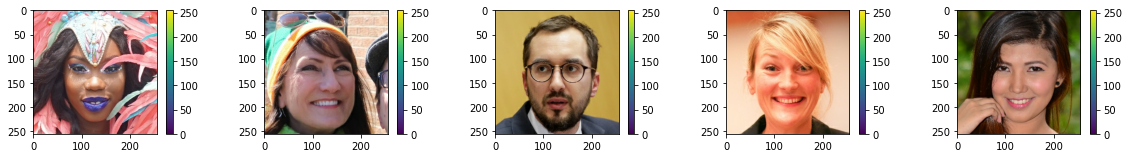

In [ ]:
# Examine the data
image_batch, label_batch = next(iter(train_ds))
n = 5
plt.figure(figsize=(20, 5))
for i in range(n):
  # display image & pixel values
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.colorbar()
  plt.grid(False)
plt.show()

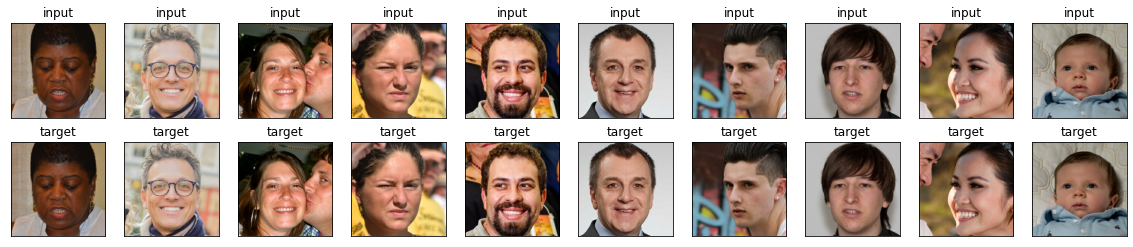

In [ ]:
# Let's check that input is the same as the target
image_batch, label_batch = next(iter(val_ds))
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title("input")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(label_batch[i].numpy().astype("uint8"))
  plt.title("target")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Normalize the images to [0.,1.] (test set only)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), normalization_layer(y)))
val_ds = val_ds.map(lambda x,y: (normalization_layer(x), normalization_layer(y)))
test_ds = test_ds.map(lambda x,y: (normalization_layer(x), normalization_layer(y)))


In [ ]:
# class AutoEncoder(tf.keras.Model):
#   def __init__(self):
#     super(AutoEncoder, self).__init__()
#     self.encoder = tf.keras.Sequential([
#       tf.keras.layers.Input(shape=(256, 256, 3)),
#       # tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
#       tf.keras.layers.Conv2D(168, (3,3), activation='relu', padding='same', strides=2),
#       tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', strides=2),
#       tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2)])
    
#     self.decoder = tf.keras.Sequential([
#       tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
#       tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
#       tf.keras.layers.Conv2DTranspose(168, kernel_size=3, strides=2, activation='relu', padding='same'),
#       tf.keras.layers.Conv2D(3, kernel_size=(3,3), activation='relu', padding='same')])
    
#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# autoencoder = AutoEncoder()

In [ ]:
# The previous implementation with the subclassing API of keras does not support
# the .save method. I used the same model implemented with the functional API 
# to be able to save it so I don't have to train it every time.
inpts_enc = tf.keras.layers.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(168, (3,3), activation='relu', padding='same', strides=2)(inpts_enc)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', strides=2)(x)
outpts_enc = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2)(x)

inpts_dec = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(outpts_enc)
y = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(inpts_dec)
y = tf.keras.layers.Conv2DTranspose(168, kernel_size=3, strides=2, activation='relu', padding='same')(y)
outpts_dec = tf.keras.layers.Conv2D(3, kernel_size=(3,3), activation='relu', padding='same')(y)

# decoder = tf.keras.Model(inputs=inpts_dec, outputs=outpts_dec)

autoencoder = tf.keras.Model(inputs=inpts_enc, outputs=outpts_dec)

In [ ]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss='mse', metrics='accuracy')

In [ ]:
history = autoencoder.fit(train_ds,
                epochs=10,
                validation_data=val_ds)

Epoch 1/10
110/110 [==============================] - 3505s 31s/step - loss: 0.0631 - accuracy: 0.6236 - val_loss: 0.0095 - val_accuracy: 0.7704
Epoch 2/10
110/110 [==============================] - 150s 1s/step - loss: 0.0081 - accuracy: 0.7755 - val_loss: 0.0040 - val_accuracy: 0.8446
Epoch 3/10
110/110 [==============================] - 152s 1s/step - loss: 0.0038 - accuracy: 0.8444 - val_loss: 0.0036 - val_accuracy: 0.8593
Epoch 4/10
110/110 [==============================] - 151s 1s/step - loss: 0.0034 - accuracy: 0.8538 - val_loss: 0.0032 - val_accuracy: 0.8578
Epoch 5/10
110/110 [==============================] - 151s 1s/step - loss: 0.0031 - accuracy: 0.8544 - val_loss: 0.0029 - val_accuracy: 0.8610
Epoch 6/10
110/110 [==============================] - 151s 1s/step - loss: 0.0030 - accuracy: 0.8671 - val_loss: 0.0022 - val_accuracy: 0.8882
Epoch 7/10
110/110 [==============================] - 151s 1s/step - loss: 0.0022 - accuracy: 0.8915 - val_loss: 0.0020 - val_accuracy: 0.91

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 168)     4704      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        96832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 256, 256, 168)     96936 

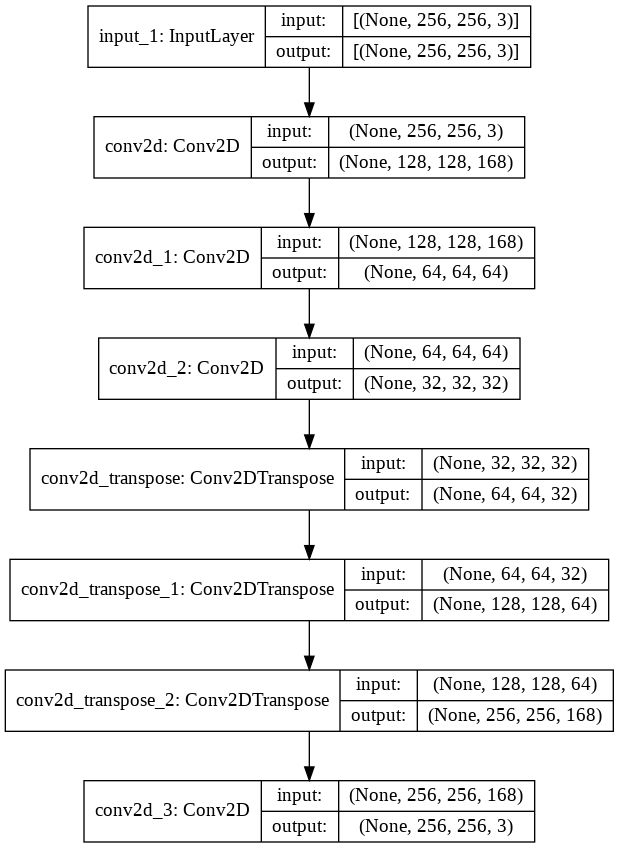

In [ ]:
# plot the model
plot_model(autoencoder, 'autoencoder.png', show_shapes=True)

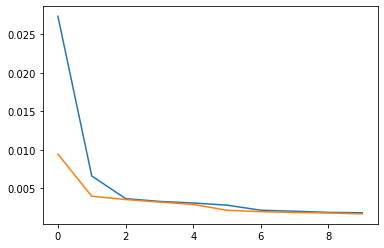

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

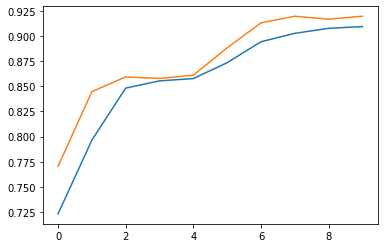

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
# Instantiate encoder
encoder = tf.keras.Model(inputs=inpts_enc, outputs=outpts_enc)

# Save encoder part of the model for use in the classification task
encoder.save('drive/MyDrive/DeepFake/encoder.h5')

In [ ]:
# Evaluate the model with the test set
autoencoder.evaluate(test_ds)

24/24 [==============================] - 582s 21s/step - loss: 0.0017 - accuracy: 0.9180


[0.001699620857834816, 0.9180233478546143]

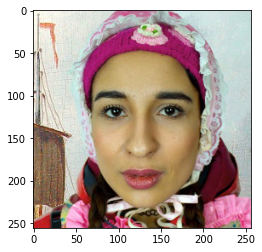

In [ ]:
# test_ds original images are not shown so I try an alternative to see 
# if the model works properly
test_img = plt.imread('/content/drive/MyDrive/DeepFake/samples/2.jpg')
plt.imshow(test_img)
plt.show()

In [ ]:
test_img = test_img/255.
decoded_img = autoencoder(tf.expand_dims(test_img,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


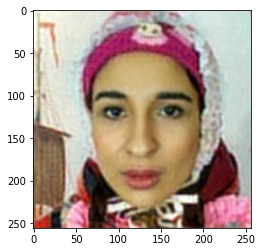

In [ ]:
plt.imshow(decoded_img[0])
plt.show()

# Classification

In [3]:
data_dir_clas = "/content/drive/MyDrive/DeepFake/dataset2/"

In [4]:
 data_dir_classif = pathlib.Path(data_dir_clas)

In [5]:
# Split the path for the two folders to gain a balanced dataset
data_dir_real = pathlib.Path(data_dir_clas + 'real')
data_dir_fake = pathlib.Path(data_dir_clas + 'fake')

list_ds_real = tf.data.Dataset.list_files(str(data_dir_real/'*'), shuffle=False)
list_ds_fake = tf.data.Dataset.list_files(str(data_dir_fake/'*'), shuffle=False)

In [6]:
percentage = 0.3 # must be < 0.5
list_ds_real=list_ds_real.take(int(percentage*len(list_ds_real)))
list_ds_fake=list_ds_fake.take(int(percentage*len(list_ds_fake)))

In [7]:
list_ds_clas = tf.data.Dataset.concatenate(list_ds_real, list_ds_fake)
list_ds_clas = list_ds_clas.shuffle(len(list_ds_clas), reshuffle_each_iteration=False)

In [ ]:
for f in list_ds_clas.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/DeepFake/dataset2/fake/11FUEXPZEV.jpg'
b'/content/drive/MyDrive/DeepFake/dataset2/real/13011.jpg'
b'/content/drive/MyDrive/DeepFake/dataset2/fake/0RRFALUYK6.jpg'
b'/content/drive/MyDrive/DeepFake/dataset2/real/05895.jpg'
b'/content/drive/MyDrive/DeepFake/dataset2/fake/1QY6I7Y64V.jpg'


In [8]:
# Make label names
class_names = np.array(sorted([item.name for item in data_dir_classif.glob('*')]))
print(class_names)

['fake' 'real']


In [9]:
# Split train, validation and test datasets

# Split the sets to 80%, 10%, 10%
train_size = int(0.8 * len(list_ds_clas))
val_size = int(0.1 * len(list_ds_clas))

train_ds_clas = list_ds_clas.take(train_size)
tmp_ds_clas = list_ds_clas.skip(train_size)
val_ds_clas = tmp_ds_clas.take(val_size)
test_ds_clas = tmp_ds_clas.skip(val_size)

In [ ]:
# Check if the sets have the correct number of samples
print(len(list_ds_clas),len(train_ds_clas), len(val_ds_clas), len(test_ds_clas))

6000 4800 600 600


In [10]:
# Function for dataset preperation in classification
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer one hot encode the label
  return int(one_hot)

def decode_img_clas(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [256, 256])

def process_path_clas(file_path):
  # print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img_clas(img)
  return img, label

In [11]:

train_ds_clas = train_ds_clas.map(process_path_clas)
val_ds_clas = val_ds_clas.map(process_path_clas)
test_ds_clas = test_ds_clas.map(process_path_clas)

In [ ]:
for image, label in train_ds_clas.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  [1 0]
Image shape:  (256, 256, 3)
Label:  [0 1]
Image shape:  (256, 256, 3)
Label:  [1 0]
Image shape:  (256, 256, 3)
Label:  [0 1]
Image shape:  (256, 256, 3)
Label:  [1 0]


In [ ]:
for image, label in val_ds_clas.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  [0 1]
Image shape:  (256, 256, 3)
Label:  [1 0]
Image shape:  (256, 256, 3)
Label:  [1 0]
Image shape:  (256, 256, 3)
Label:  [0 1]
Image shape:  (256, 256, 3)
Label:  [0 1]


In [ ]:
for image, label in test_ds_clas.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  [1 0]
Image shape:  (256, 256, 3)
Label:  [0 1]
Image shape:  (256, 256, 3)
Label:  [0 1]
Image shape:  (256, 256, 3)
Label:  [1 0]
Image shape:  (256, 256, 3)
Label:  [1 0]


In [12]:
def ds_config(ds):
  ds = ds.batch(128)
  return ds

train_ds_clas = ds_config(train_ds_clas).shuffle(buffer_size=100)
val_ds_clas = ds_config(val_ds_clas)
test_ds_clas = ds_config(test_ds_clas)

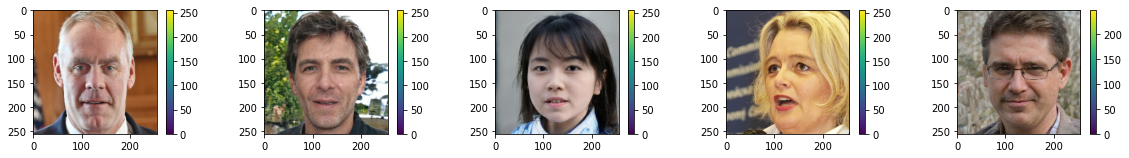

In [ ]:
# Examine the data
image_batch, label_batch = next(iter(train_ds_clas))
n = 5
plt.figure(figsize=(20, 5))
for i in range(n):
  # display image & pixel values
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.colorbar()
  plt.grid(False)
plt.show()

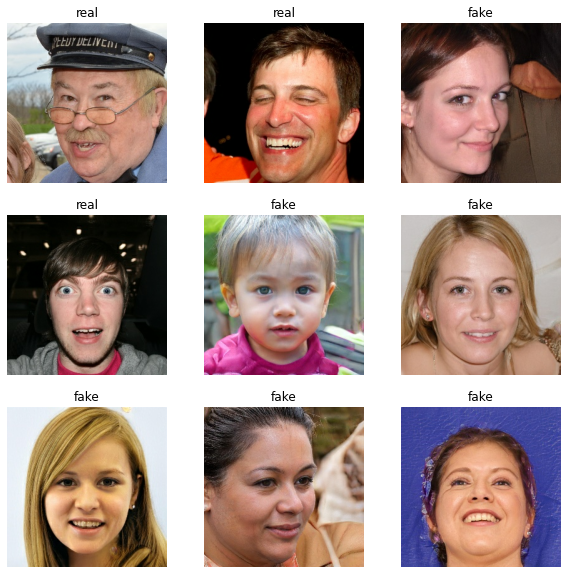

In [13]:
image_batch, label_batch = next(iter(val_ds_clas))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  # convert one hot encoding to zeros and ones.
  label = np.argmax(list(map(bool, label_batch[i])))
  plt.title(class_names[label])
  plt.axis("off")

In [14]:
# Normalize the images to [0.,1.]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)
train_ds_clas = train_ds_clas.map(lambda x,y: (normalization_layer(x), y))
val_ds_clas = val_ds_clas.map(lambda x,y: (normalization_layer(x),y))
test_ds_clas = test_ds_clas.map(lambda x,y: (normalization_layer(x), y))

In [15]:
# Load the encoder from file
encoder = tf.keras.models.load_model('drive/MyDrive/DeepFake/encoder.h5')

In [23]:
# Implement the classifier
layer1 = encoder
layer2 = tf.keras.layers.Flatten()
layer3 = tf.keras.layers.Dense(2, activation='softmax',
                               kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.1))

classifier = tf.keras.Sequential([layer1, layer2, layer3])

In [24]:
classifier.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
history_clas = classifier.fit(train_ds_clas, epochs=20, validation_data=val_ds_clas)

Epoch 1/20
38/38 [==============================] - 28s 348ms/step - loss: 2.6857 - accuracy: 0.5323 - precision_2: 0.5323 - recall_2: 0.5323 - val_loss: 0.8566 - val_accuracy: 0.5917 - val_precision_2: 0.5917 - val_recall_2: 0.5917
Epoch 2/20
38/38 [==============================] - 23s 329ms/step - loss: 0.8151 - accuracy: 0.6243 - precision_2: 0.6243 - recall_2: 0.6243 - val_loss: 0.7610 - val_accuracy: 0.6350 - val_precision_2: 0.6350 - val_recall_2: 0.6350
Epoch 3/20
38/38 [==============================] - 23s 331ms/step - loss: 0.7643 - accuracy: 0.6298 - precision_2: 0.6298 - recall_2: 0.6298 - val_loss: 0.7670 - val_accuracy: 0.6050 - val_precision_2: 0.6050 - val_recall_2: 0.6050
Epoch 4/20
38/38 [==============================] - 22s 330ms/step - loss: 0.7480 - accuracy: 0.6349 - precision_2: 0.6349 - recall_2: 0.6349 - val_loss: 0.7744 - val_accuracy: 0.6133 - val_precision_2: 0.6133 - val_recall_2: 0.6133
Epoch 5/20
38/38 [==============================] - 23s 331ms/step -

In [19]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 32, 32, 32)        120000    
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 65538     
Total params: 185,538
Trainable params: 185,538
Non-trainable params: 0
_________________________________________________________________


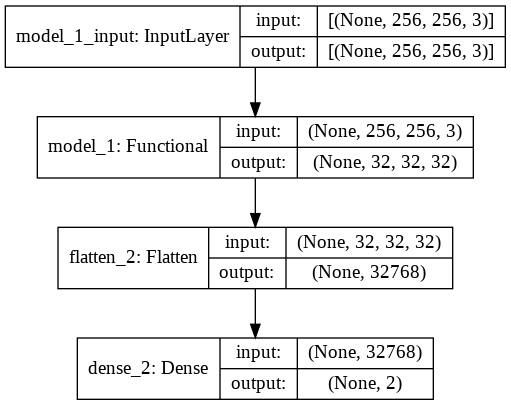

In [29]:
# Plot the classifier
plot_model(classifier, 'classifier.png', show_shapes=True)

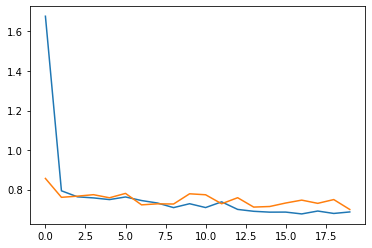

In [30]:
plt.plot(history_clas.history['loss'])
plt.plot(history_clas.history['val_loss'])
plt.show()

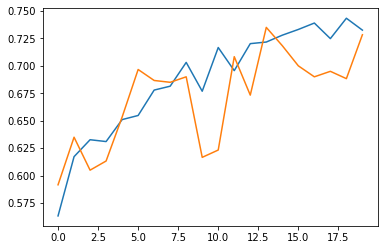

In [31]:
plt.plot(history_clas.history['accuracy'])
plt.plot(history_clas.history['val_accuracy'])
plt.show()

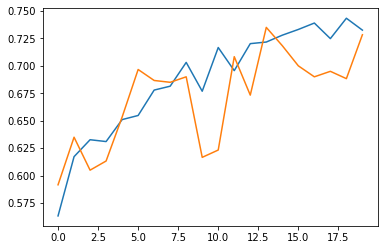

In [33]:
plt.plot(history_clas.history['precision_2'])
plt.plot(history_clas.history['val_precision_2'])
plt.show()

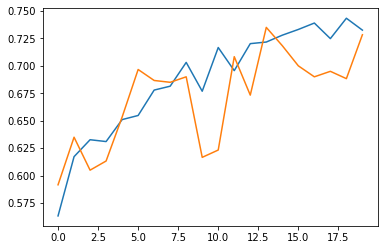

In [34]:
plt.plot(history_clas.history['recall_2'])
plt.plot(history_clas.history['val_recall_2'])
plt.show()

In [35]:
# Evaluate the performance of the classifier
classifier.evaluate(test_ds_clas)

5/5 [==============================] - 152s 30s/step - loss: 0.7203 - accuracy: 0.6983 - precision_2: 0.6983 - recall_2: 0.6983


[0.7202666401863098,
 0.6983333230018616,
 0.6983333230018616,
 0.6983333230018616]

# Optional subtask

In [41]:
# Import the images from samples folder
image_list = []
for filename in glob.glob('/content/*.jpg'): 
    im = plt.imread(filename)
    image_list.append(im)

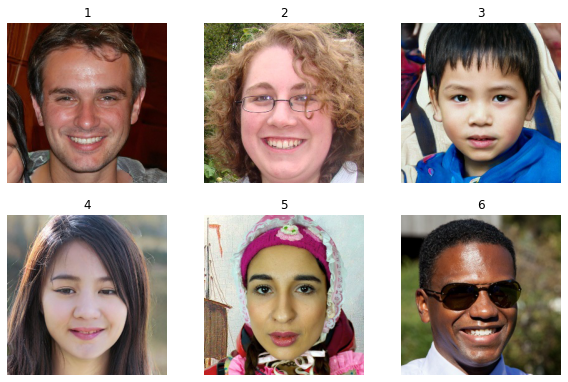

In [46]:
# Examine images
plt.figure(figsize=(10, 10))
for i, image in enumerate(image_list, 1):
  ax = plt.subplot(3, 3, i-1 + 1)
  plt.imshow(image)
  plt.title(i)
  plt.axis("off")


In [47]:
for i, image in enumerate(image_list):
  image_list[i] = tf.expand_dims(image/255., 0)


In [48]:
tt = tf.data.Dataset.from_tensor_slices(image_list)
classified = classifier.predict(tt)
print(classified)


[[0.4371662  0.5628338 ]
 [0.6060826  0.39391732]
 [0.59835744 0.40164256]
 [0.62500703 0.37499294]
 [0.5071038  0.49289626]
 [0.2657548  0.73424524]]
